In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
ALPHA = 0.5

In [4]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

def calculate_bleu_score(true_sentence, generated_sentence):
    # Use a smoothing function to avoid BLEU score being zero
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu(
        [true_sentence.split()], 
        generated_sentence.split(), 
        smoothing_function=smoothing_function
    )

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [5]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [6]:
model_map = {
    'base': 'CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    'echocrypt': 'EchoCrypt',
}

In [7]:
main_dir = '.'

In [8]:
# Data holder for plotting
results = []
file_counter = 0

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', ''))
                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    if file_counter < 3:
                        results.append({
                            'Model': model_map['base'], # CoAtNet
                            'Noise Factor': nf,
                            'Levenshtein Accuracy': base_leven,
                            'BLEU Accuracy': base_bleu,
                            'Meteor Score': base_meteor,
                            'Rouge-1': base_rouge1,
                            'Rouge-2': base_rouge2,
                            'Rouge-L': base_rougeL,
                            'Adjusted Accuracy': base_combined,
                        })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })
        file_counter += 3


In [9]:
results_df = pd.DataFrame(results)
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())
# results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,CoAtNet,1.0,0.971154,0.503534,0.800666,0.812500,0.600000,0.812500,0.737344
1,LLAMA-3.2-3B,1.0,1.000000,1.000000,0.999878,1.000000,1.000000,1.000000,1.000000
2,CoAtNet,1.0,0.946237,0.128961,0.543478,0.615385,0.333333,0.615385,0.537599
3,LLAMA-3.2-3B,1.0,1.000000,1.000000,0.999818,1.000000,1.000000,1.000000,1.000000
4,CoAtNet,1.0,0.968254,0.534174,0.801768,0.842105,0.705882,0.842105,0.751214
...,...,...,...,...,...,...,...,...,...
17995,LLAMA-3.2-1B,1.5,0.888889,0.039281,0.142857,0.285714,0.000000,0.285714,0.464085
17996,LLAMA-3.2-1B,1.5,0.867470,0.570675,0.806362,0.782609,0.666667,0.782609,0.719072
17997,LLAMA-3.2-1B,1.5,0.500000,0.056122,0.372000,0.500000,0.111111,0.500000,0.278061
17998,LLAMA-3.2-1B,1.5,0.933333,0.698931,0.886200,0.857143,0.736842,0.857143,0.816132


In [10]:

mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()

/var/folders/64/2d7c040x5bg5nwx3jpncnr080000gn/T/ipykernel_4072/2869310711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
/var/folders/64/2d7c040x5bg5nwx3jpncnr080000gn/T/ipykernel_4072/2869310711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()


In [11]:
mean_df.to_excel('mean.xlsx', index=False)
std_df.to_excel('std.xlsx', index=False)

In [12]:
std_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Model                 18 non-null     category
 1   Noise Factor          18 non-null     float64 
 2   Levenshtein Accuracy  18 non-null     float64 
 3   BLEU Accuracy         18 non-null     float64 
 4   Meteor Score          18 non-null     float64 
 5   Rouge-1               18 non-null     float64 
 6   Rouge-2               18 non-null     float64 
 7   Rouge-L               18 non-null     float64 
 8   Adjusted Accuracy     18 non-null     float64 
dtypes: category(1), float64(8)
memory usage: 1.5 KB


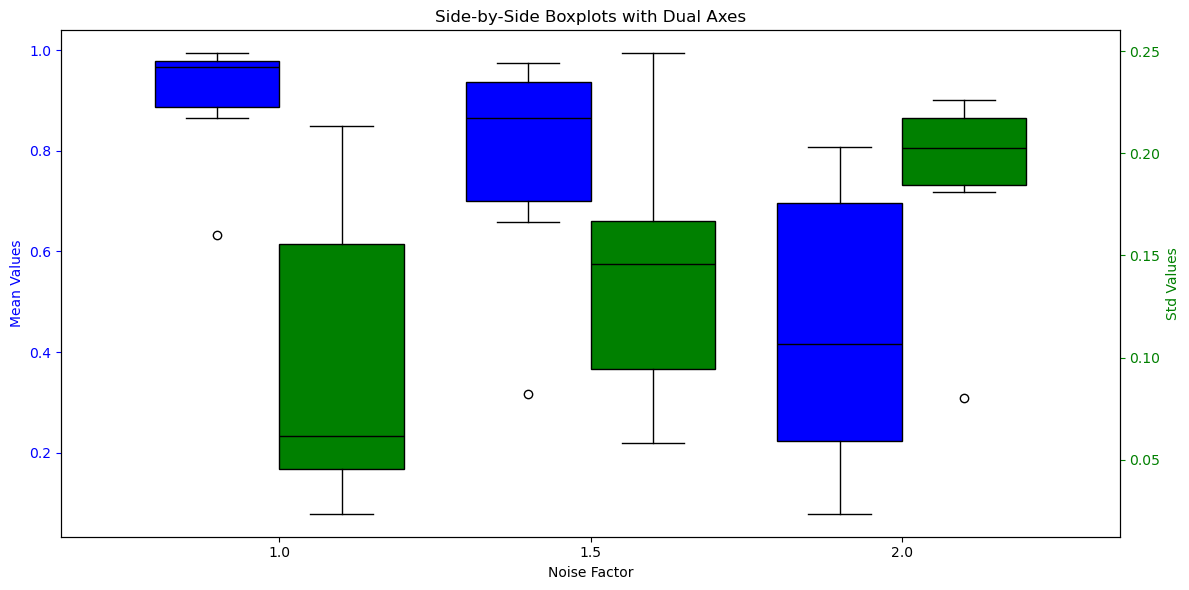

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframes for seaborn
mean_melted = mean_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Mean')
std_melted = std_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Std')

# Merge the mean and std dataframes
merged_df = pd.merge(mean_melted, std_melted, on=['Model', 'Noise Factor', 'Metric'])

# Filter for Meteor Score only
merged_df = merged_df[merged_df['Metric'] == 'Meteor Score']
noise_factors = sorted(merged_df['Noise Factor'].unique())

# Restructure the data for Mean and Std separately
mean_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Mean']})
std_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Std']})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define offsets for side-by-side boxplots
x_positions = np.arange(len(noise_factors))
bar_width = 0.4

# Plot the Mean boxplots on the primary y-axis
ax1.boxplot(
    [mean_data[mean_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions - bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='blue'),
    medianprops=dict(color='black')
)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the Std boxplots on the secondary y-axis
ax2.boxplot(
    [std_data[std_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions + bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='green'),
    medianprops=dict(color='black')
)

# Customize the axes
ax1.set_xticks(x_positions)
ax1.set_xticklabels(noise_factors)
ax1.set_xlabel('Noise Factor')
ax1.set_ylabel('Mean Values', color='blue')
ax2.set_ylabel('Std Values', color='green')
ax1.set_title('Side-by-Side Boxplots with Dual Axes')

# Customize tick colors for clarity
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='green')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [15]:
# Separate data for each plot
def plot_accuracy(df, accuracy_type):
    plt.figure(figsize=(10, 6))
    for model in model_map.values():
        model_data = df[df['Model'] == model]
        plt.plot(model_data['Noise Factor'], model_data[accuracy_type], marker='o', label=model)
        # print model, nf, accuracy_type, accuracy
        print(f"Base Model: Phone, Model: {model}, NF: {model_data['Noise Factor'].values}, {accuracy_type}: {model_data[accuracy_type].values}")

    plt.xlabel('Noise Factor', fontweight='bold')
    plt.ylabel(f'{accuracy_type}', fontweight='bold')
    plt.title(f'Phone Model', fontweight='bold') # (alpha={ALPHA})
    
    # Bold tick numbers
    # plt.xticks(fontweight='bold')
    # plt.yticks(fontweight='bold')
    
    plt.legend()
    plt.savefig(f'{accuracy_type.replace(' ', '_').replace('-', '_')}_phone.pdf', format='pdf')
    plt.show()

In [16]:
# Plot Levenshtein Accuracy
# plot_accuracy(results_df, 'Levenshtein Accuracy')

# Plot BLEU Accuracy
# plot_accuracy(results_df, 'BLEU Accuracy')

# Plot Combined Accuracy
# plot_accuracy(results_df, 'Adjusted Accuracy')

# Plot Meteor Score
# plot_accuracy(results_df, 'Meteor Score')

# Plot Rouge-1
# plot_accuracy(results_df, 'Rouge-1')

# Plot Rouge-2
# plot_accuracy(results_df, 'Rouge-2')

# Plot Rouge-L
# plot_accuracy(results_df, 'Rouge-L')

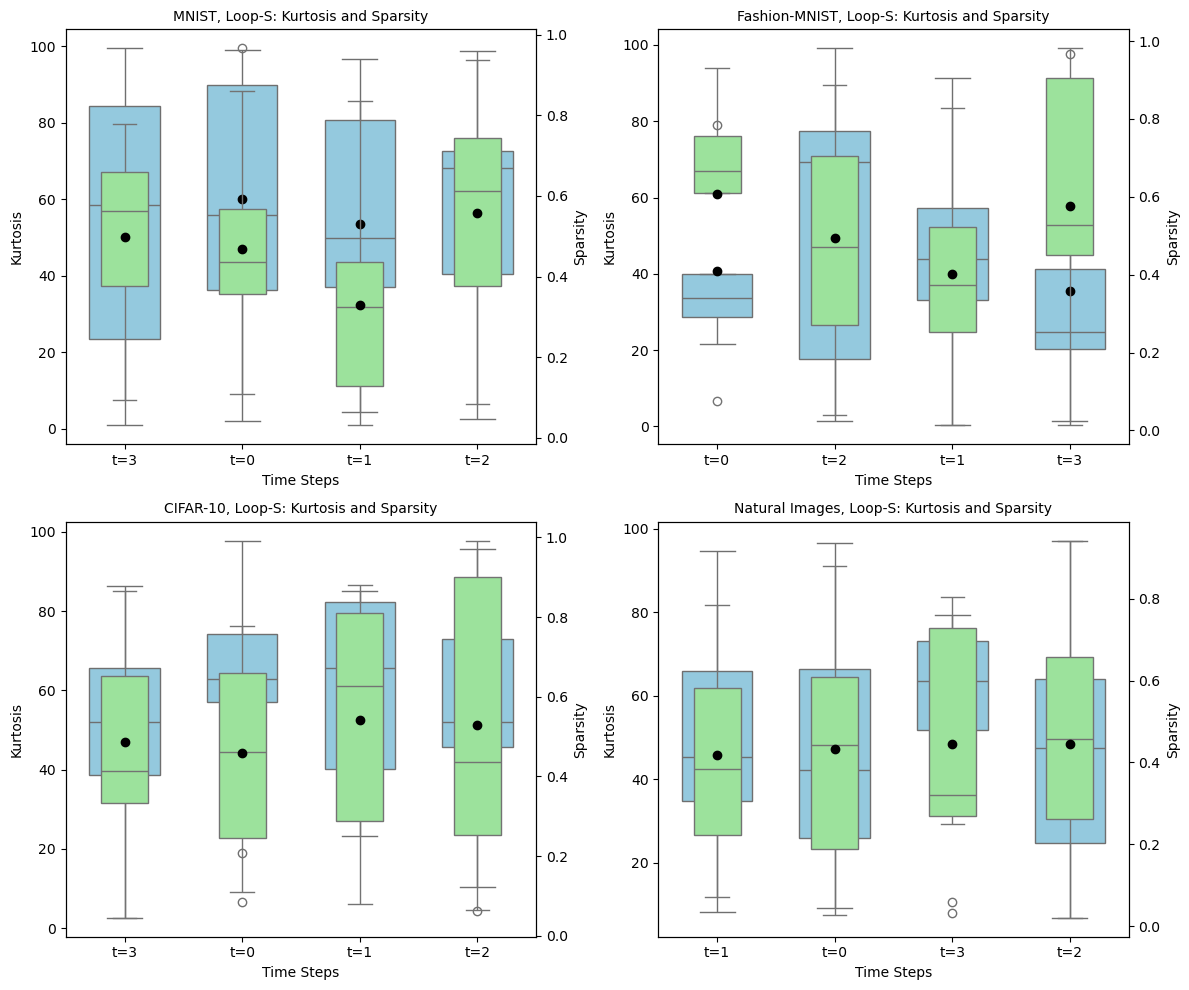

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example DataFrame
data = {
    'Dataset': np.random.choice(['MNIST', 'Fashion-MNIST', 'CIFAR-10', 'Natural Images'], 200),
    'Time Steps': np.random.choice(['t=0', 't=1', 't=2', 't=3'], 200),
    'Kurtosis': np.random.rand(200) * 100,
    'Sparsity': np.random.rand(200),
}
df = pd.DataFrame(data)

# Initialize the grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=False)
datasets = ['MNIST', 'Fashion-MNIST', 'CIFAR-10', 'Natural Images']

# Plot each dataset in a separate subplot
for ax, dataset in zip(axes.flatten(), datasets):
    subset = df[df['Dataset'] == dataset]
    
    # Create boxplot for Kurtosis
    sns.boxplot(
        x='Time Steps', y='Kurtosis', data=subset, ax=ax, color='skyblue',
        width=0.6, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )
    
    # Add secondary axis for Sparsity
    ax2 = ax.twinx()
    sns.boxplot(
        x='Time Steps', y='Sparsity', data=subset, ax=ax2, color='lightgreen',
        width=0.4, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )
    
    # Set labels and title
    ax.set_title(f'{dataset}, Loop-S: Kurtosis and Sparsity', fontsize=10)
    ax.set_ylabel('Kurtosis')
    ax2.set_ylabel('Sparsity')

# Adjust layout
plt.tight_layout()
plt.show()
